In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Dense, Lambda, LSTM, Bidirectional, Input, RepeatVector, Concatenate, Dot

Using TensorFlow backend.


In [0]:
import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM

In [0]:
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 50
LATENT_DIM = 256
VOCAB_SIZE = 20000
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
NUM_SAMPLES = 10000
EPOCHS=100

In [7]:
print('Loading dataset...')

input_texts = []
target_text_input = []
target_text = []
with open('/content/gdrive/My Drive/Colab Notebooks/spa.txt') as f:
    count = 0
    for line in f:
        count += 1
        if count > NUM_SAMPLES:
            break
        
        if '\t' not in line:
            continue
        input_, translation = line.rstrip().split('\t')
        input_texts.append(input_)
        target_text_input.append('<sos> ' + translation)
        target_text.append(translation + ' <eos>')

Loading dataset...


In [8]:
encoded_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
encoded_tokenizer.fit_on_texts(input_texts)
encoded_sequence = encoded_tokenizer.texts_to_sequences(input_texts)

word2idx_inputs = encoded_tokenizer.word_index

print('No of input words %d' % (len(word2idx_inputs)+1))

max_len_input = max([len(s) for s in encoded_sequence])

No of input words 2365


In [0]:
decoded_tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='')
decoded_tokenizer.fit_on_texts(target_text + target_text_input)
target_sequence = decoded_tokenizer.texts_to_sequences(target_text)
target_input_sequence = decoded_tokenizer.texts_to_sequences(target_text_input)

word2idx_target = decoded_tokenizer.word_index
num_words_output = len(word2idx_target) + 1

max_len_target = max(len(s) for s in target_sequence)

In [10]:
encoded_sequence = pad_sequences(encoded_sequence, maxlen=max_len_input)
print('encoded inputs shape', encoded_sequence.shape)

target_sequence = pad_sequences(target_sequence, maxlen=max_len_target, padding='post')
target_input_sequence = pad_sequences(target_input_sequence, maxlen=max_len_target, padding='post')
print('target_input_sequence shape', target_input_sequence.shape)

encoded inputs shape (10000, 5)
target_input_sequence shape (10000, 9)


In [11]:
word2vec = {}
with open('/content/gdrive/My Drive/Colab Notebooks/glove.6B.%sd.txt' % EMBEDDING_DIM, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
    print('No of word vectors %d' % len(word2vec))

No of word vectors 400000


In [12]:
print('Filling pre-trained...')
num_words_input = min(VOCAB_SIZE, len(word2idx_inputs)+1)
embedding_matrix = np.zeros((num_words_input, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < VOCAB_SIZE:
        embedding_vector = word2idx_inputs.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Filling pre-trained...


In [0]:
encoder_embedding = Embedding(
    num_words_input,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=max_len_input,
    trainable=False
)

In [0]:
# decoder_output_one_hot = np.zeros((len(input_texts), max_len_target, num_words_output), dtype='float32')

# for i, d in enumerate(target_sequence):
#     for j, word in enumerate(d):
#         decoder_output_one_hot[i, j, word] = 1

In [0]:
def batch_generator(batch_size, data_len, encoder_x, decoder_x, decoder_y):
    counter = 0
    while True:
        encoder_i = encoder_x[counter*batch_size:min((counter+1)*batch_size, data_len)]
        decoder_i = decoder_x[counter*batch_size:min((counter+1)*batch_size, data_len)]
        decoder_o = decoder_y[counter*batch_size:min((counter+1)*batch_size, data_len)]
        length = min((counter+1)*batch_size, data_len)-counter*batch_size
        decoder_one_hot = np.zeros((length, max_len_target, num_words_output), dtype='float32')
        for i, d in enumerate(decoder_o):
            for t, word in enumerate(d):
                decoder_one_hot[i, t, word] = 1
        counter+=1
        if counter*batch_size >= data_len:
            counter=0
        z = np.zeros((length, LATENT_DIM))
        yield [encoder_i, decoder_i, z, z], decoder_one_hot

In [0]:
random_idx = np.random.randint(0, len(input_texts), len(input_texts))

In [0]:
validation_split = 0.2
validation_size = int(validation_split*len(encoded_sequence))
train_len = len(encoded_sequence)-validation_size

train_idx = random_idx[validation_size:]
valid_idx = random_idx[:validation_size]

In [0]:
train_encoder_input = encoded_sequence[train_idx]
valid_encoder_input = encoded_sequence[valid_idx]

train_decoder_input = target_input_sequence[train_idx]
valid_decoder_input = target_input_sequence[valid_idx]

train_decoder_output = target_sequence[train_idx]
valid_decoder_output = target_sequence[valid_idx]

In [0]:
train_gen = batch_generator(BATCH_SIZE, train_len, train_encoder_input, train_decoder_input, train_decoder_output)
valid_gen = batch_generator(BATCH_SIZE, validation_size, valid_encoder_input, valid_decoder_input, valid_decoder_output)

In [23]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
encoder_x = encoder_embedding(encoder_inputs_placeholder)
encoder_lstm = Bidirectional(LSTM(LATENT_DIM, return_sequences=True))
encoder_outputs = encoder_lstm(encoder_x)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def softmax_over_time(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(x, axis=1, keepdims=True)
    return e/s

In [0]:
attention_repeat_layer = RepeatVector(max_len_input)
attention_concat_layer = Concatenate(axis=-1)
attention_dense_layer1 = Dense(10, activation='tanh')
attention_dense_layer2 = Dense(1, activation=softmax_over_time)
attention_dot_layer = Dot(axes=1)

In [0]:
def one_step_attention(h, st_1):
    
    st_1 = attention_repeat_layer(st_1)
    x = attention_concat_layer([h, st_1])
    x = attention_dense_layer1(x)
    alphas = attention_dense_layer2(x)
    context = attention_dot_layer([alphas, h])
    
    return context

In [0]:
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM, trainable=True)
decoder_x = decoder_embedding(decoder_inputs_placeholder)
decoder_lstm = LSTM(LATENT_DIM, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

In [0]:
initial_s = Input(shape=(LATENT_DIM,), name='s0')
initial_c = Input(shape=(LATENT_DIM,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

In [0]:
outputs = []
s = initial_s
c = initial_c
for t in range(max_len_target):
    context = one_step_attention(encoder_outputs, s)
    selector = Lambda(lambda x: x[:, t:t+1])
    xt = selector(decoder_x)
    decoder_lstm_input = context_last_word_concat_layer([context, xt])
    o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])
    decoder_outputs = decoder_dense(o)
    outputs.append(decoder_outputs)

In [0]:
def stack_and_transpose(x):
    x = K.stack(x)
    x = K.permute_dimensions(x, pattern=(1, 0, 2))
    return x

In [0]:
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

In [0]:
model = Model(
    inputs =[
        encoder_inputs_placeholder,
        decoder_inputs_placeholder,
        initial_s,
        initial_c
    ],
    outputs=outputs
)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [41]:
r = model.fit_generator(train_gen,
                       steps_per_epoch=train_len//BATCH_SIZE,
                       epochs=EPOCHS,
                       validation_data=valid_gen,
                       validation_steps=validation_size//BATCH_SIZE)

Epoch 1/100
125/125 [==============================] - 9s 74ms/step - loss: 3.2632 - acc: 0.5923 - val_loss: 2.3751 - val_acc: 0.6903
Epoch 2/100
125/125 [==============================] - 5s 42ms/step - loss: 2.3947 - acc: 0.6651 - val_loss: 2.2841 - val_acc: 0.6930
Epoch 3/100
125/125 [==============================] - 5s 40ms/step - loss: 2.2770 - acc: 0.6895 - val_loss: 2.1901 - val_acc: 0.6958
Epoch 4/100
125/125 [==============================] - 5s 40ms/step - loss: 2.0693 - acc: 0.6974 - val_loss: 2.1201 - val_acc: 0.7027
Epoch 5/100
125/125 [==============================] - 5s 40ms/step - loss: 1.9484 - acc: 0.7040 - val_loss: 2.0804 - val_acc: 0.7024
Epoch 6/100
125/125 [==============================] - 5s 40ms/step - loss: 1.8861 - acc: 0.7069 - val_loss: 1.9988 - val_acc: 0.7116
Epoch 7/100
125/125 [==============================] - 5s 40ms/step - loss: 1.7921 - acc: 0.7145 - val_loss: 1.9508 - val_acc: 0.7174
Epoch 8/100
125/125 [==============================] - 5s 40ms

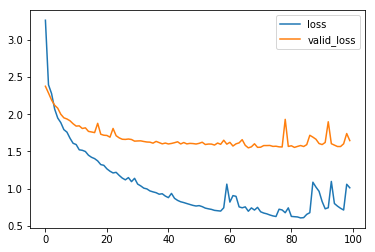

In [42]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='valid_loss')
plt.legend()
plt.show()

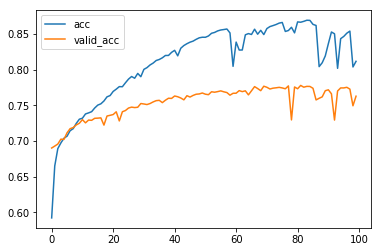

In [43]:
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='valid_acc')
plt.legend()
plt.show()

In [0]:
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

In [0]:
encoder_output_as_input = Input(shape=(max_len_input, LATENT_DIM*2,))
decoder_input_single = Input(shape=(1,))
decoder_input_x = decoder_embedding(decoder_input_single)
context = one_step_attention(encoder_output_as_input, initial_s)
decoder_lstm_input = context_last_word_concat_layer([context, decoder_input_x])

o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

In [0]:
decoder_model = Model(
    inputs=[encoder_output_as_input,
           decoder_input_single,
           initial_s,
           initial_c],
    outputs=[decoder_outputs, s, c]
)

In [0]:
idx2word_input = {v:k for k,v in word2idx_inputs.items()}
idx2word_target = {v:k for k,v in word2idx_target.items()}

In [0]:
def decode_sequence(input_seq):
    
    enc_out = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0,0] = word2idx_target['<sos>']
    eos = word2idx_target['<eos>']
    
    s = np.zeros((1, LATENT_DIM))
    c = np.zeros((1, LATENT_DIM))
    
    output_sentence = []
    
    for _ in range(max_len_target):
        o, s, c = decoder_model.predict([enc_out, target_seq, s, c])
        
        idx = np.argmax(o.flatten())
        
        if idx == eos:
            break
        
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)
            
        target_seq[0, 0] = idx
    return ' '.join(output_sentence)

In [49]:
while True:
    i = np.random.choice(len(input_texts))
    input_seq = encoded_sequence[i:i+1]
    translation = decode_sequence(input_seq)
    print('-')
    print('input_sequence', input_texts[i])
    print('Predicted translation', translation)
    print('Actual translation', target_text[i])
    
    ans = input('Continue? [Y/n]')
    
    if ans and ans.lower().startswith('n'):
        break

-
input_sequence Skip it.
Predicted translation ayúdame.
Actual translation Sáltatelo. <eos>
Continue? [Y/n]y
-
input_sequence I'm still busy.
Predicted translation no soy bajo.
Actual translation Todavía estoy ocupada. <eos>
Continue? [Y/n]y
-
input_sequence You look busy.
Predicted translation no podés ir.
Actual translation Pareces ocupado. <eos>
Continue? [Y/n]y
-
input_sequence Are you kidding?
Predicted translation ¿estás en casa?
Actual translation ¿Estás jodiendo? <eos>
Continue? [Y/n]n
